In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import glob

In [21]:
results_df = pd.read_csv("../machine_DSI_output.csv", header=0, sep=",")

In [22]:
human_and_machine = pd.read_csv("../machine_and_human_DSI_output.csv", header=0, sep=",")#

In [23]:
human_and_machine.keys()

Index(['DSI', 'story', 'model', 'condition', 'temp'], dtype='object')

In [24]:
human_and_machine['condition'].unique()

array(['haiku'], dtype=object)

In [25]:
# remove human haikus
human_and_machine = human_and_machine.loc[human_and_machine["model"] != "human"]

In [26]:
human_and_machine['temp'].unique()

array(['Very Low', 'Low', 'Mid', 'High', 'Very High'], dtype=object)

In [27]:
human_haiku = pd.read_csv("../human_DSI_output.csv", header=0, sep=",")
# replace temp n.a with Mid
human_haiku['temp'].replace('n.a', 'Mid', inplace=True)

In [28]:
human_stories = pd.read_csv("../DSI_output.csv", header=0, sep=",")

In [29]:
human_haiku.keys()

Index(['DSI', 'story', 'model', 'condition', 'temp'], dtype='object')

In [30]:
results_df.keys()

Index(['DSI', 'story', 'model', 'condition', 'temp'], dtype='object')

In [31]:
human_stories.keys()

Index(['ID', 'word_count', 'readability', 'freq', 'aoa', 'prev', 'mtld',
       'Story', 'StoryRater1', 'StoryRater2', 'StoryRater3', 'StoryRater4',
       'StoryRater5', 'StoryRaterMean', 'sex', 'age', 'english', 'gc', 'gf',
       'gr', 'verb_sd', 'open', 'DSI_ukwac', 'DSI_subtitle', 'DSI_baroni',
       'DSI_glove', 'DSI_TASA', 'DSI_mean', 'DSI_bert', 'DSI'],
      dtype='object')

In [32]:
# replace column name
human_stories = human_stories[['Story', 'DSI']]
human_stories.columns = ['story', 'DSI']
# fill a columns with human label
human_stories['model'] = ['human'] * len(human_stories)
# fill a columns with synopsis label
human_stories['condition'] = ['flash-fiction'] * len(human_stories)
# fill a columns with temp label
human_stories['temp'] = ['Mid'] * len(human_stories)

In [33]:
results_df = pd.concat([results_df, human_haiku, human_stories, human_and_machine], axis=0)
results_df.to_csv("concateanated_reuslts_stories.csv", index=False)

Works: synopsis Mid
Works: synopsis High
synopsis Very Low
synopsis Low
synopsis Very High
Works: flash-fiction Mid
Works: flash-fiction High
flash-fiction Very Low
flash-fiction Low
flash-fiction Very High
Works: haiku Mid
Works: haiku High
Works: haiku Very Low
Works: haiku Low
Works: haiku Very High


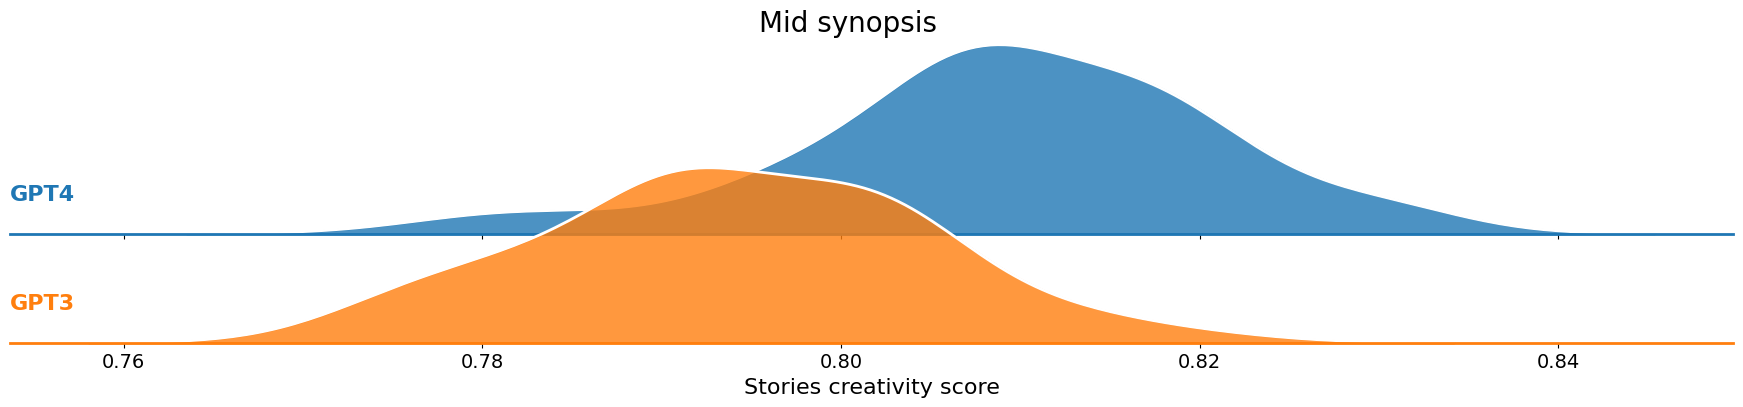

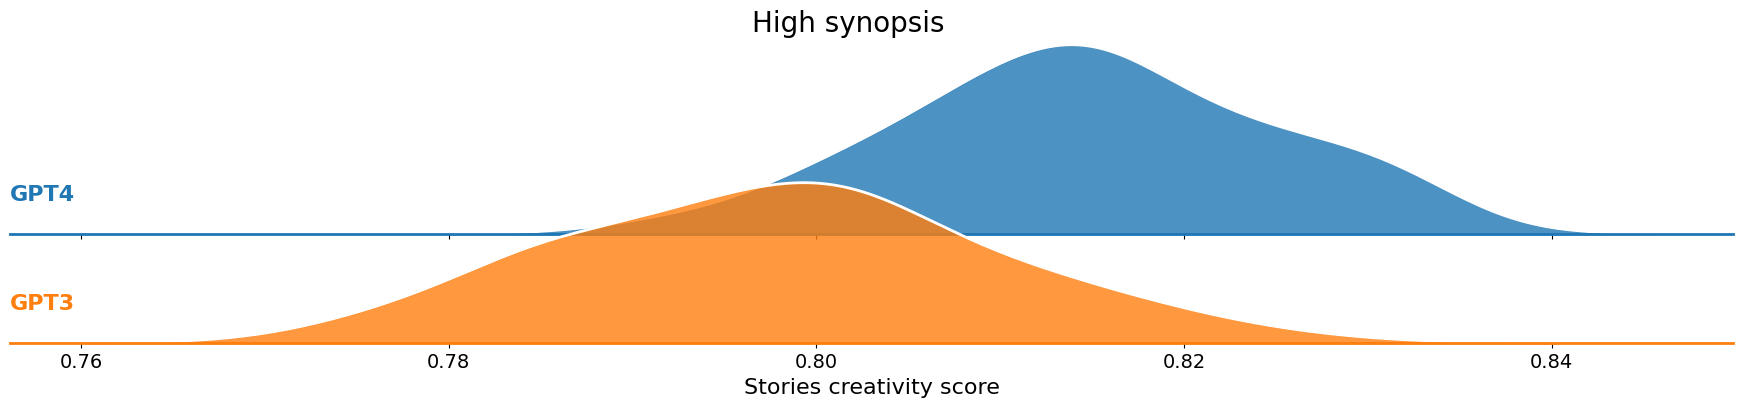

<Figure size 1800x0 with 0 Axes>

<Figure size 1800x0 with 0 Axes>

<Figure size 1800x0 with 0 Axes>

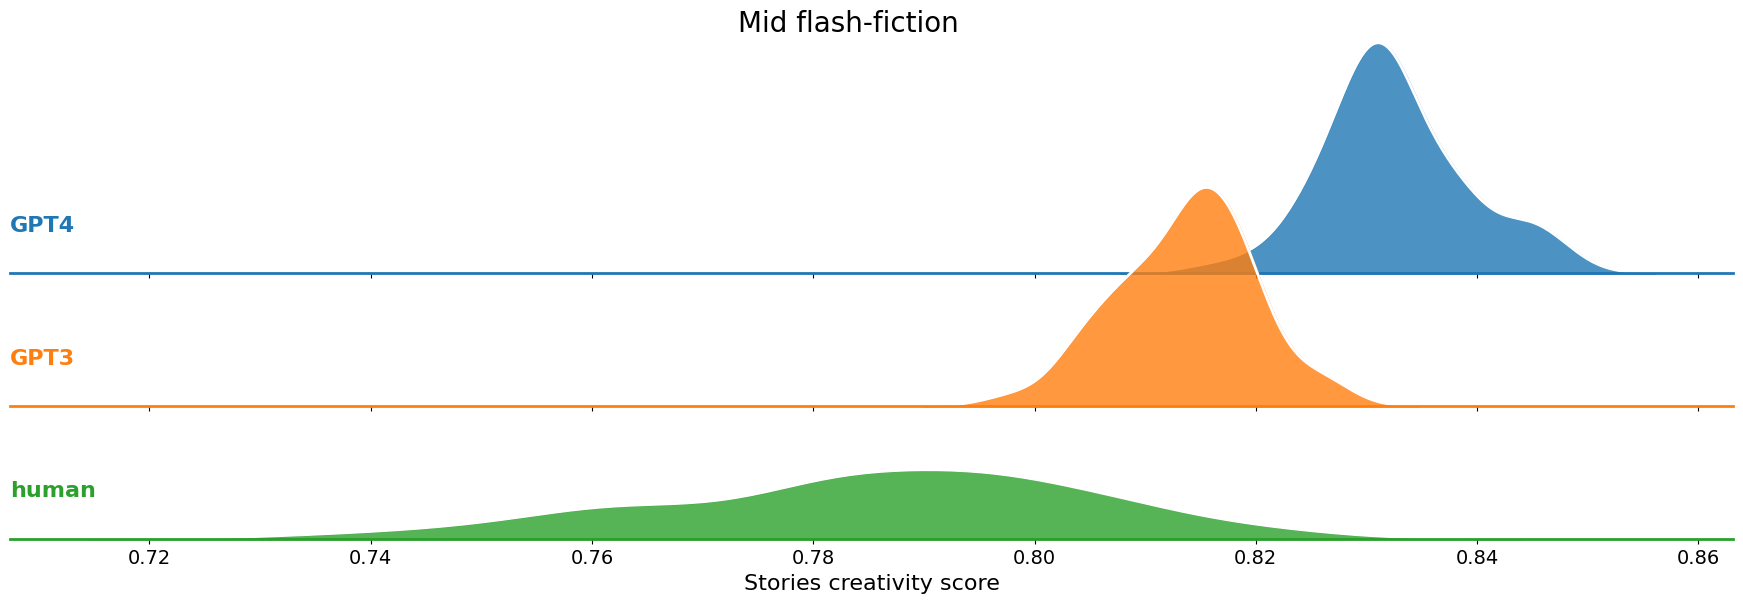

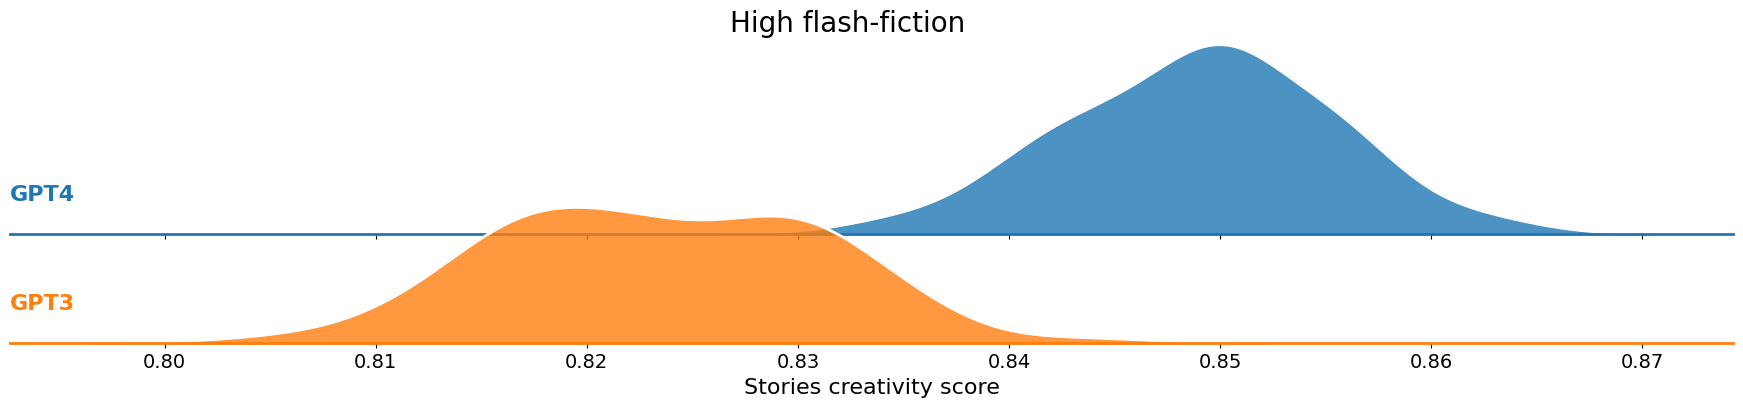

<Figure size 1800x0 with 0 Axes>

<Figure size 1800x0 with 0 Axes>

<Figure size 1800x0 with 0 Axes>

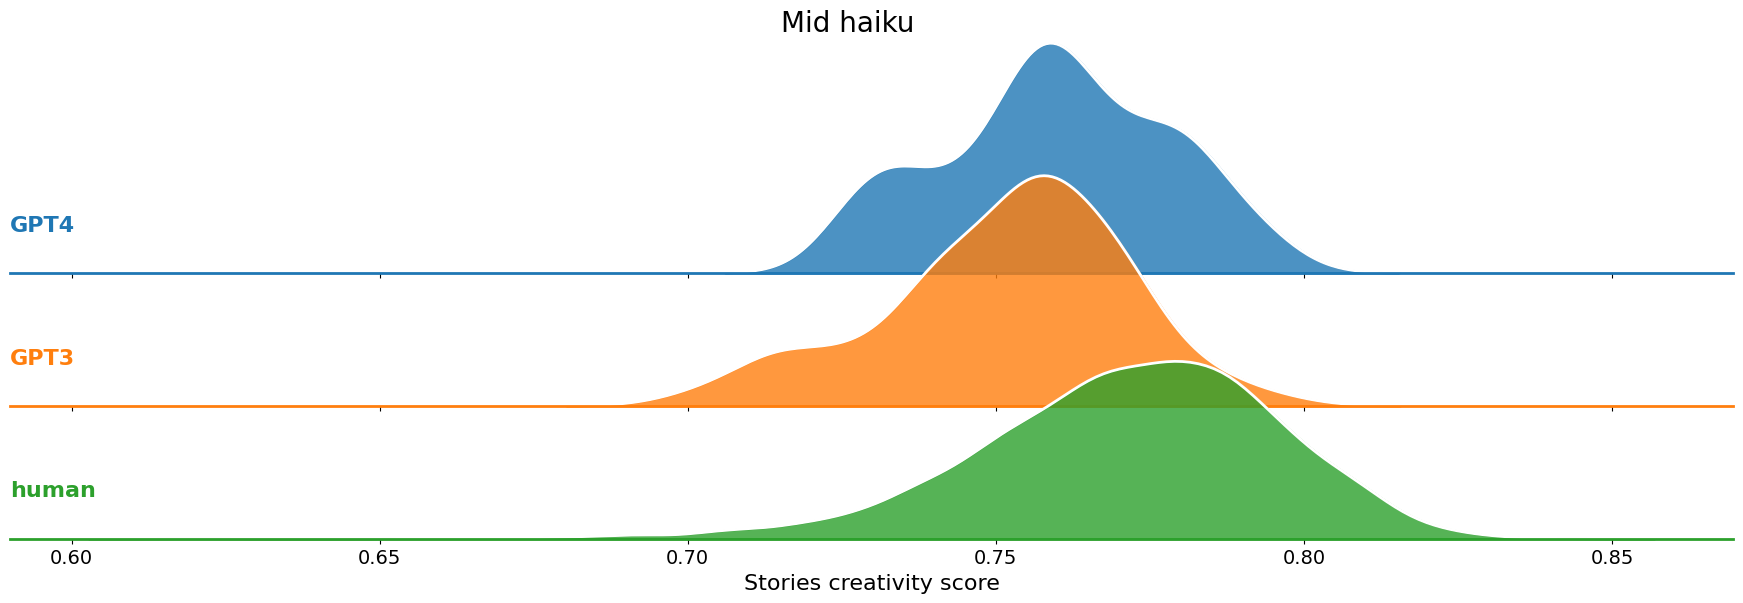

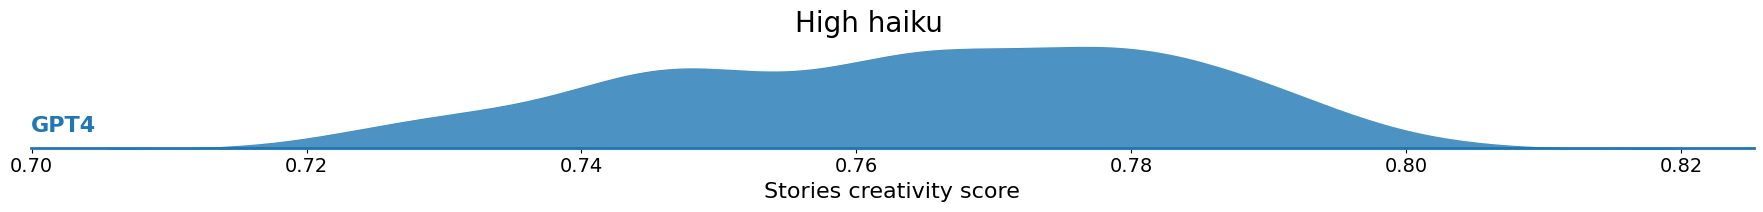

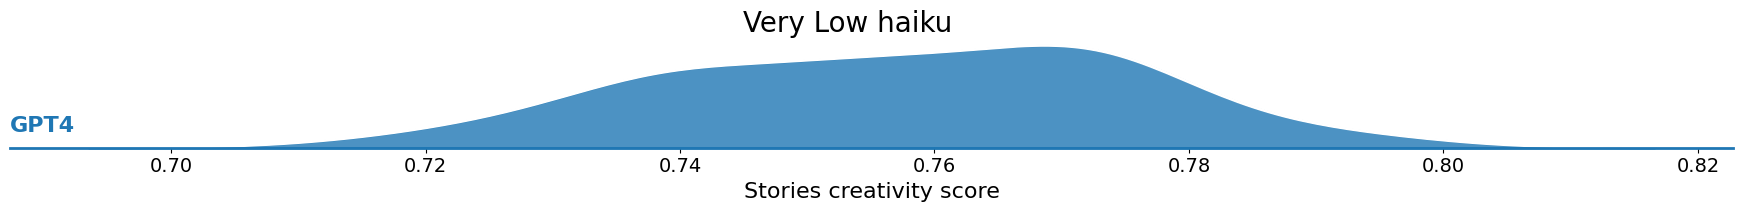

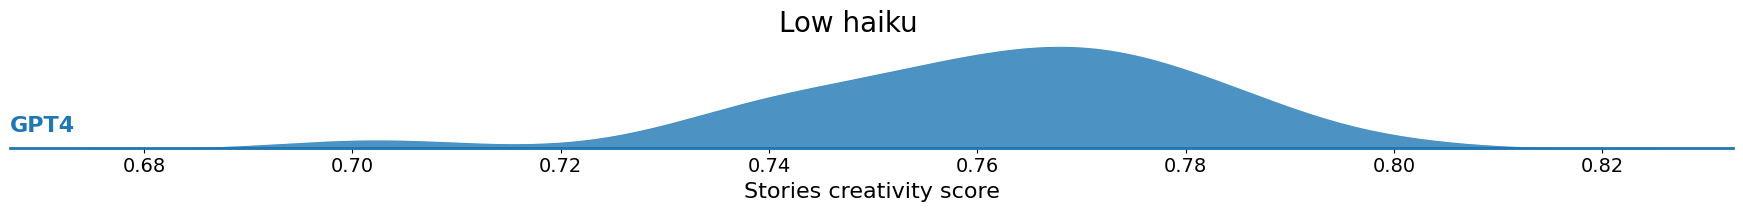

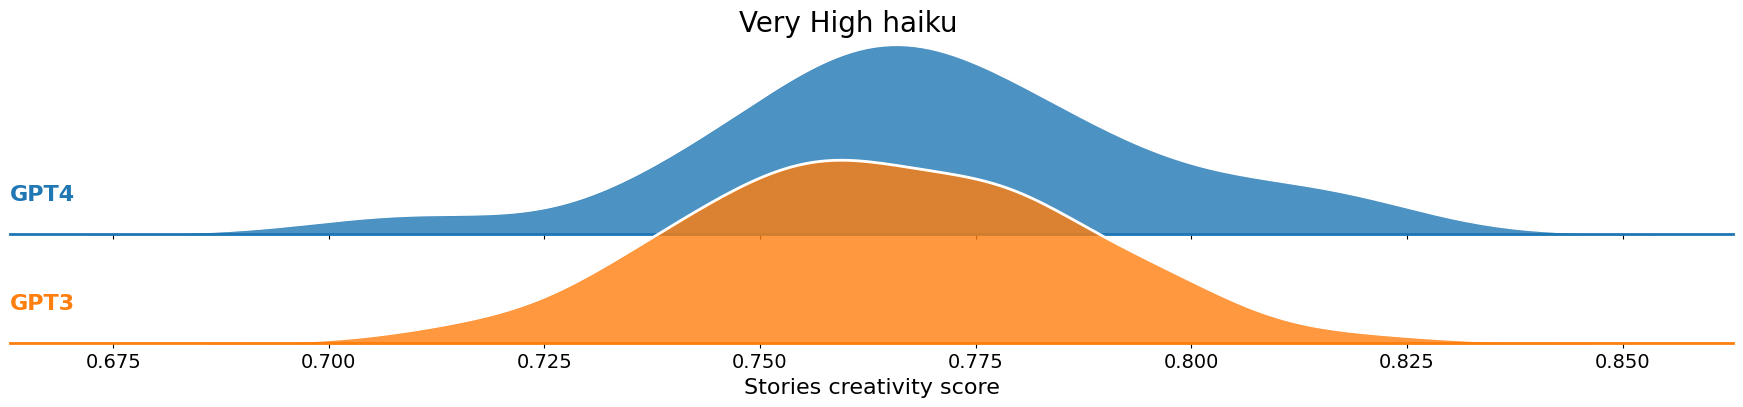

In [34]:
for condition in results_df['condition'].unique():
    for temp in results_df['temp'].unique(): 
        df = results_df[['model', 'condition', 'DSI']].loc[(results_df['condition']==condition) & (results_df['temp']==temp)]
        try:
            g = sns.FacetGrid(df, row="model", hue="model", aspect=9, height=2,)
            print("Works:", condition, temp)
        except ValueError:
            print(condition, temp)
            continue

        # make transparent background
        for ax in g.axes.flat:
            ax.set_facecolor('none')
        # Draw the densities in a few steps
        g.map(sns.kdeplot, "DSI",
            bw_adjust=1, clip_on=False,
            fill=True, alpha=0.8, linewidth=1.5)
        g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
        # passing color=None to refline() uses the hue mapping
        g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
        # Define and use a simple function to label the plot in axes coordinates
        def label(x, color, label):
            ax = plt.gca()
            # check if Human is in the label
            ax.text(0, .2, label, fontweight="bold", color=color,
                    ha="left", va="center", transform=ax.transAxes,fontsize=16)
        g.map(label, "DSI")


        for ax in g.axes.flat:
            ax.set_xlabel('Stories creativity score', fontsize=16)
            for label in ax.get_xticklabels():
                    label.set_fontsize(14)
        # Remove axes details that don't play well with overlap
        g.set_titles("")
        # Set the subplots to overlap
        g.figure.subplots_adjust(hspace=-.45)
        g.set(yticks=[], ylabel="")
        g.despine(bottom=True, left=True)
        g.fig.suptitle(f'{temp} {condition}', fontsize=20)
        g.savefig(f'../figures/DSI_ridge_{temp}_{condition}.png', dpi=300, bbox_inches='tight')

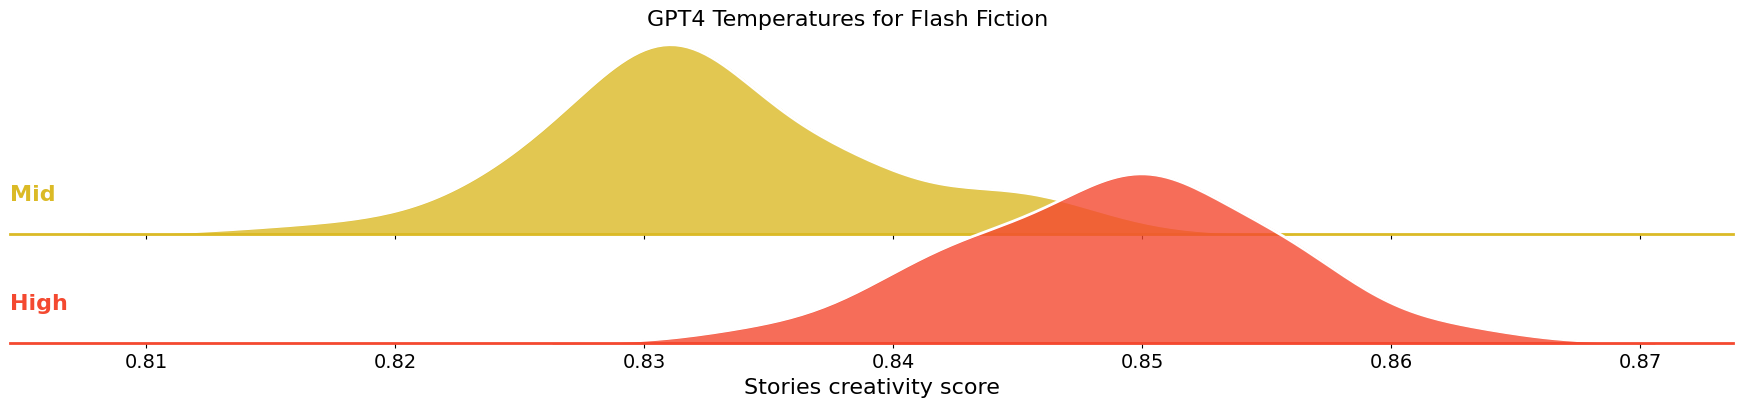

In [35]:
# Make a ridge plot like the one above looking at the effect of temperature on the DSI for each model separetaly
df = results_df.loc[(results_df['condition']=='flash-fiction') & (results_df['model']=='GPT4')]
pal = sns.color_palette('CMRmap',n_colors=3, desat=.9)
pal.reverse()
g = sns.FacetGrid(df, row="temp", hue="temp", aspect=9, height=2,palette=pal)
# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
g.map(label, "DSI")


for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# add one title for all the subplots
g.fig.suptitle('GPT4 Temperatures for Flash Fiction', fontsize=16)
g.savefig(f'../figures/GPT4_DSI_ridge_flashfiction_temp.png', dpi=300, bbox_inches='tight')

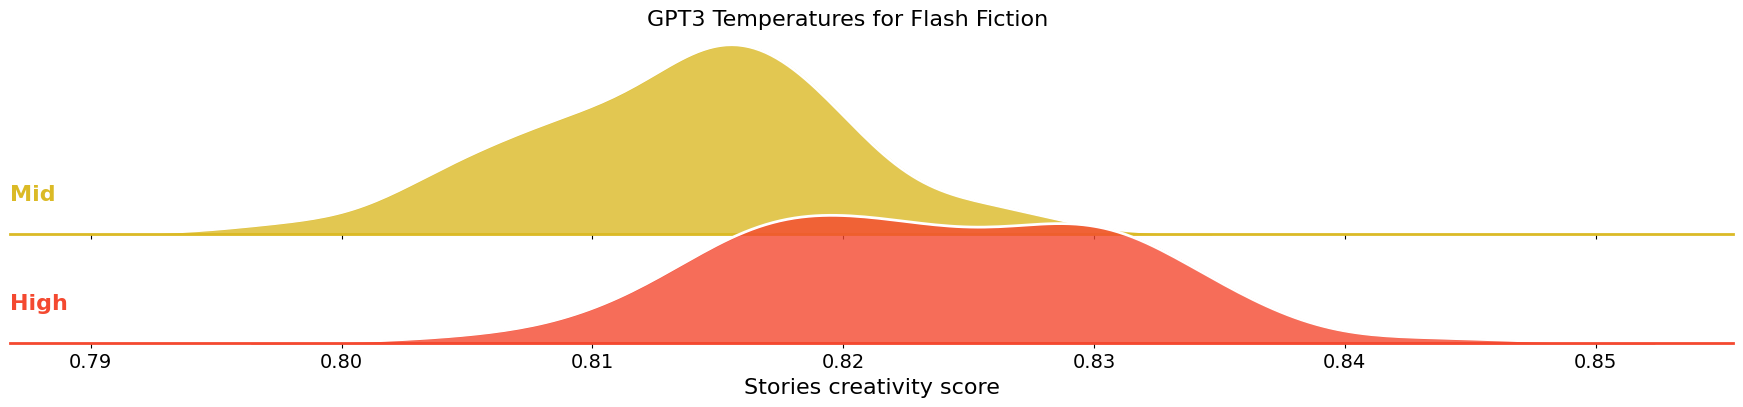

In [36]:
# Make a ridge plot like the one above looking at the effect of temperature on the DSI for each model separetaly
df = results_df.loc[(results_df['condition']=='flash-fiction') & (results_df['model']=='GPT3')]
pal = sns.color_palette('CMRmap',n_colors=3, desat=.9)
pal.reverse()
g = sns.FacetGrid(df, row="temp", hue="temp", aspect=9, height=2,palette=pal)
# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
g.map(label, "DSI")


for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# add one title for all the subplots
g.fig.suptitle('GPT3 Temperatures for Flash Fiction', fontsize=16)
g.savefig(f'../figures/GPT3_DSI_ridge_flashfiction_temp.png', dpi=300, bbox_inches='tight')

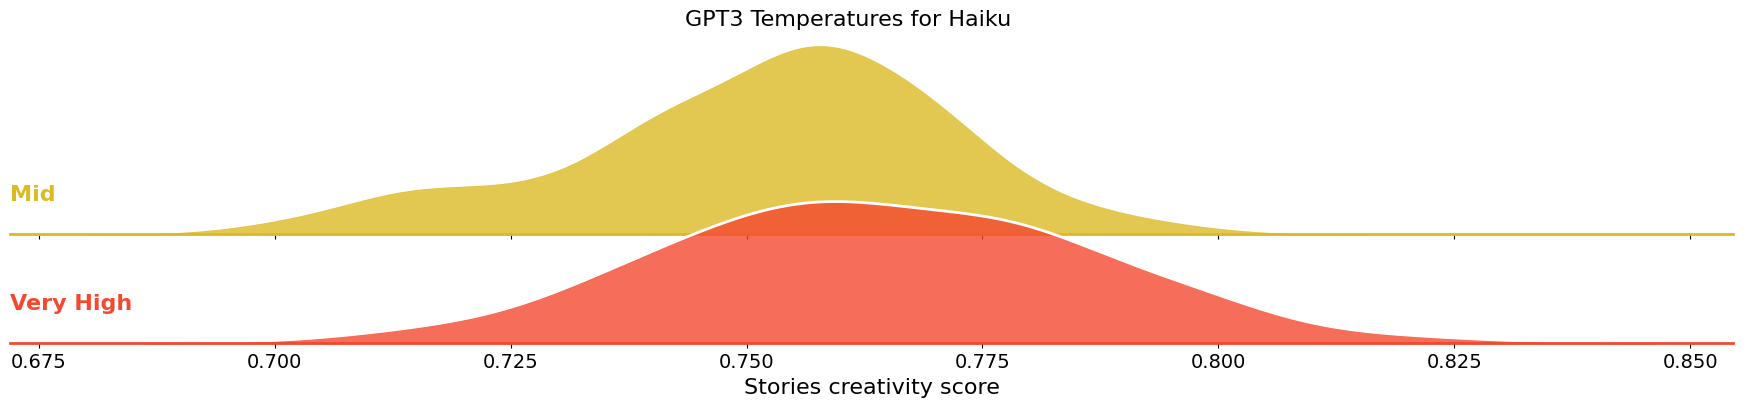

In [37]:
# Make a ridge plot like the one above looking at the effect of temperature on the DSI for each model separetaly
df = results_df.loc[(results_df['condition']=='haiku') & (results_df['model']=='GPT3')]
pal = sns.color_palette('CMRmap',n_colors=3, desat=.9)
pal.reverse()
g = sns.FacetGrid(df, row="temp", hue="temp", aspect=9, height=2,palette=pal)
# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
g.map(label, "DSI")


for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# add one title for all the subplots
g.fig.suptitle('GPT3 Temperatures for Haiku', fontsize=16)
g.savefig(f'../figures/GPT3_DSI_ridge_haiku_temp.png', dpi=300, bbox_inches='tight')

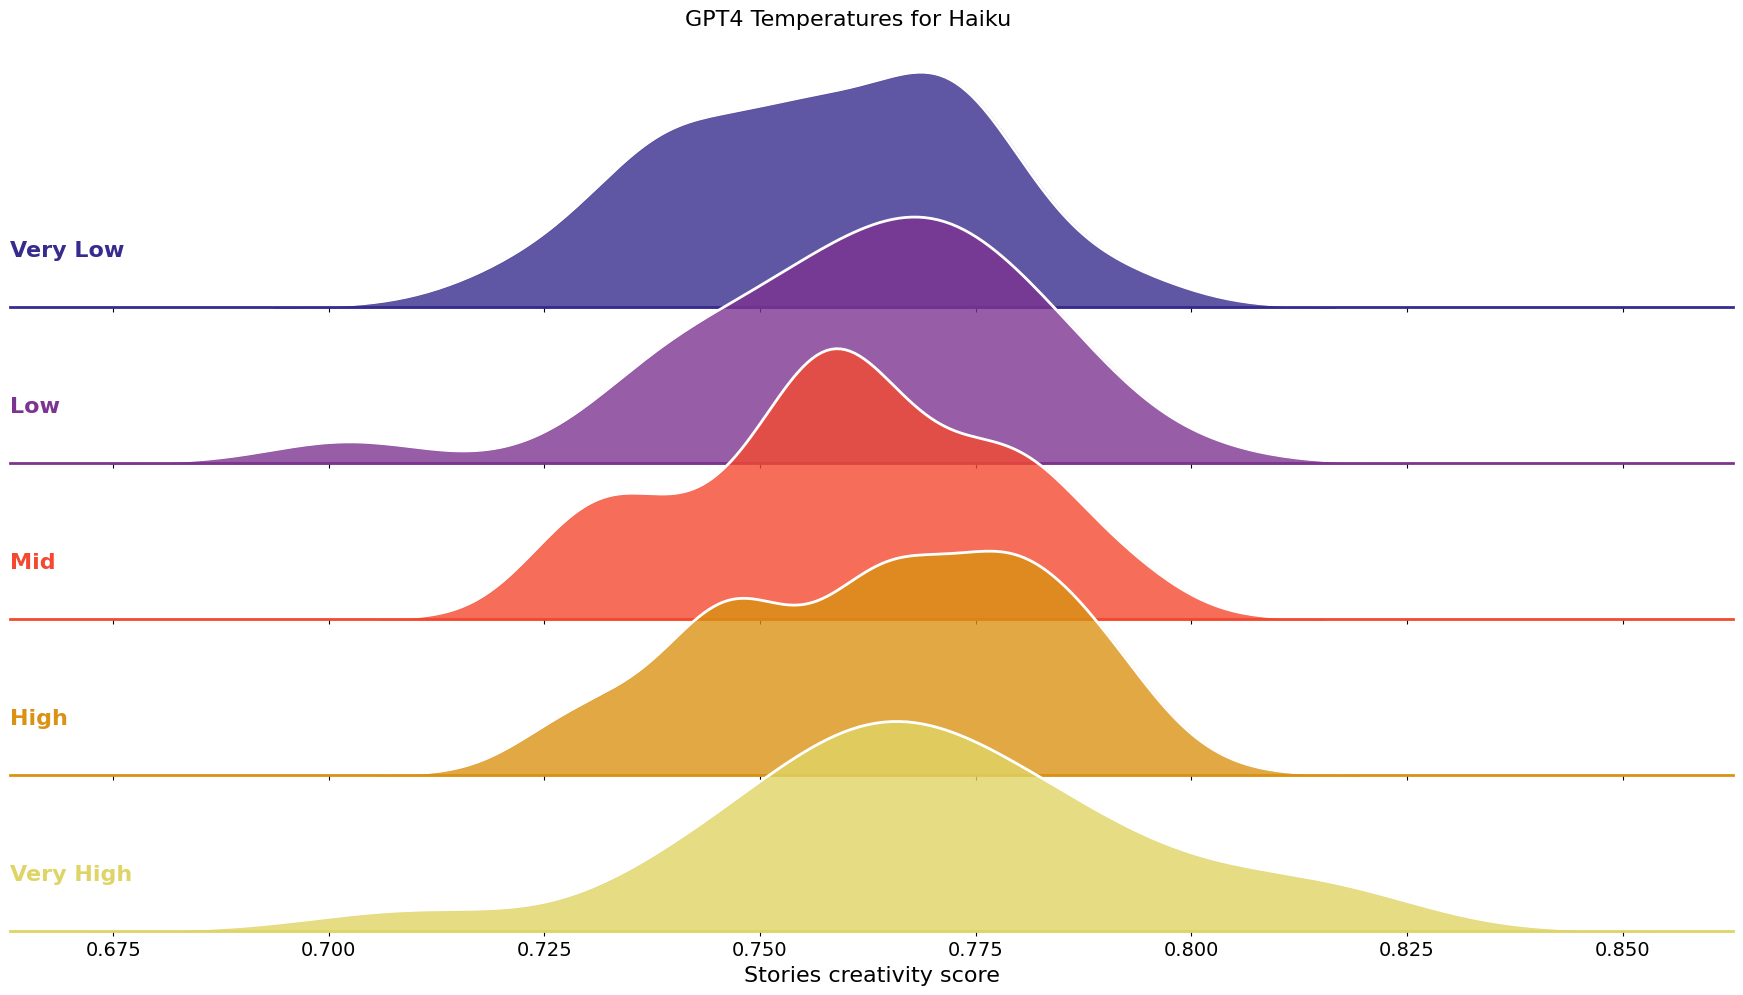

In [38]:
# Make a ridge plot like the one above looking at the effect of temperature on the DSI for each model separetaly
df = results_df.loc[(results_df['condition']=='haiku') & (results_df['model']=='GPT4')]
order = ['Very Low','Low','Mid','High','Very High']
pal = sns.color_palette('CMRmap',n_colors=5, desat=.9)
g = sns.FacetGrid(df, row="temp", hue="temp", aspect=9, height=2,palette=pal, hue_order=order, row_order=order)
# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
g.map(label, "DSI")


for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# add one title for all the subplots
g.fig.suptitle('GPT4 Temperatures for Haiku', fontsize=16)
g.savefig(f'../figures/GPT4_DSI_ridge_haiku_temp.png', dpi=300, bbox_inches='tight')

In [39]:
results_df['condition'].unique()

array(['synopsis', 'flash-fiction', 'haiku'], dtype=object)

In [40]:
results_df.loc[(results_df['condition']=='') & (results_df['model']=='GPT4')]

,DSI,story,model,condition,temp


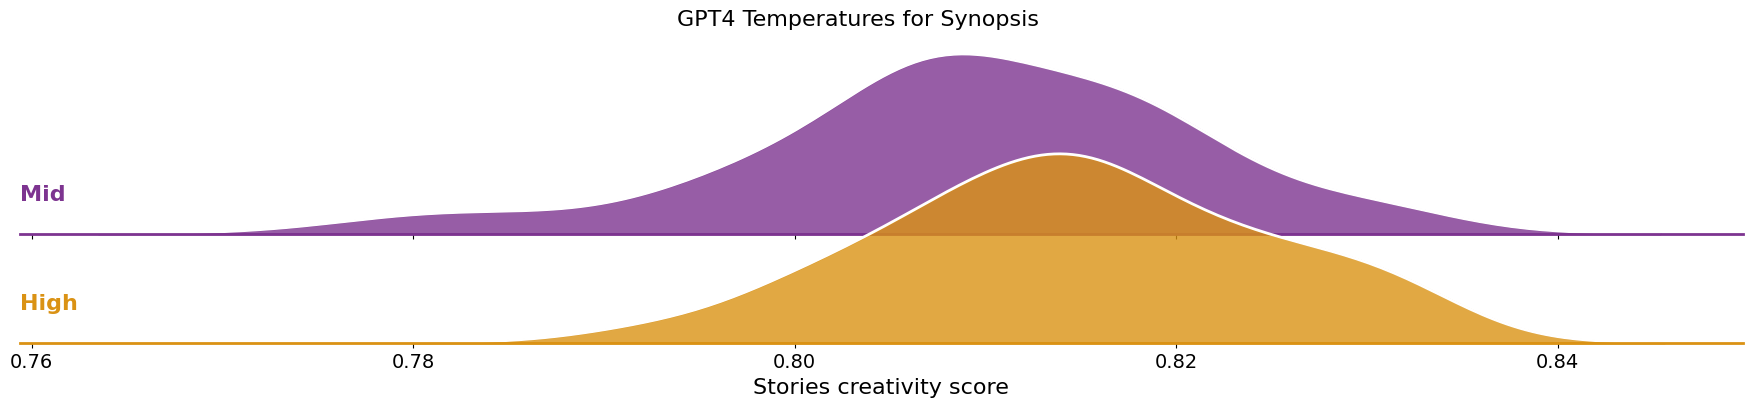

In [44]:
# Make a ridge plot like the one above looking at the effect of temperature on the DSI for each model separetaly
df = results_df.loc[(results_df['condition']=='synopsis') & (results_df['model']=='GPT4')]

pal = sns.color_palette('CMRmap',n_colors=2, desat=.9)
g = sns.FacetGrid(df, row="temp", hue="temp", aspect=9, height=2,palette=pal,)
# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
g.map(label, "DSI")


for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# add one title for all the subplots
g.fig.suptitle('GPT4 Temperatures for Synopsis', fontsize=16)
g.savefig(f'../figures/GPT4_DSI_ridge_synopsis_temp.png', dpi=300, bbox_inches='tight')

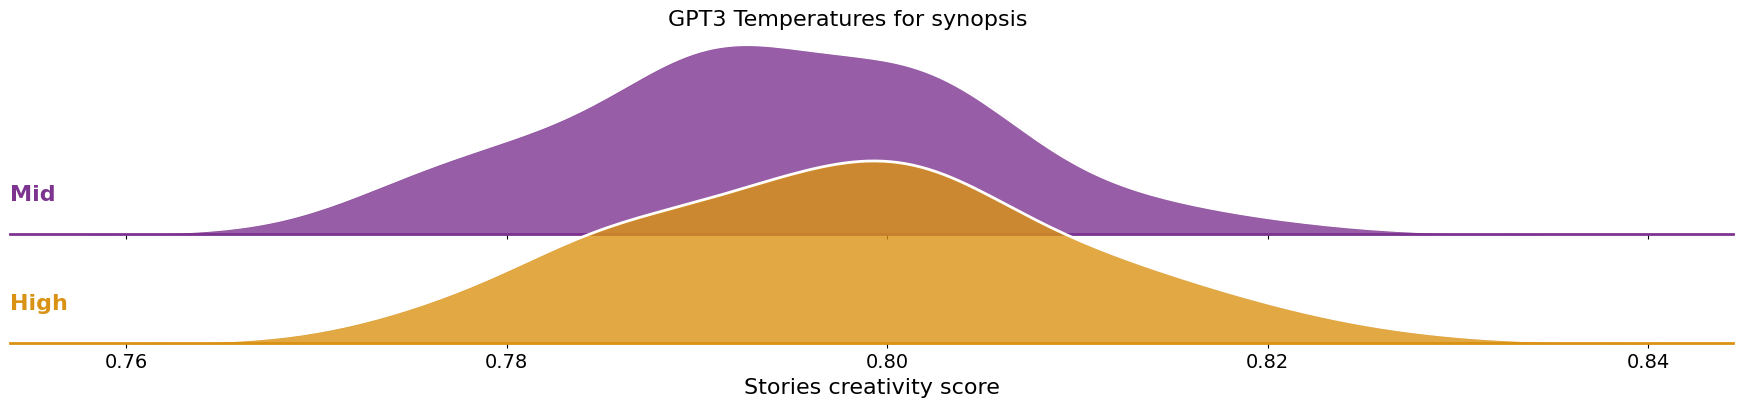

In [43]:
# Make a ridge plot like the one above looking at the effect of temperature on the DSI for each model separetaly
df = results_df.loc[(results_df['condition']=='synopsis') & (results_df['model']=='GPT3')]

pal = sns.color_palette('CMRmap',n_colors=2, desat=.9)
g = sns.FacetGrid(df, row="temp", hue="temp", aspect=9, height=2,palette=pal,)
# make transparent background
for ax in g.axes.flat:
    ax.set_facecolor('none')
# Draw the densities in a few steps
g.map(sns.kdeplot, "DSI",
    bw_adjust=1, clip_on=False,
    fill=True, alpha=0.8, linewidth=1.5)
g.map(sns.kdeplot, "DSI", clip_on=False, color="w", lw=2, bw_adjust=1)
# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)
# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    # check if Human is in the label
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes,fontsize=16)
g.map(label, "DSI")


for ax in g.axes.flat:
    ax.set_xlabel('Stories creativity score', fontsize=16)
    for label in ax.get_xticklabels():
            label.set_fontsize(14)
# Remove axes details that don't play well with overlap
g.set_titles("")
# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.45)
g.set(yticks=[], ylabel="")
g.despine(bottom=True, left=True)
# add one title for all the subplots
g.fig.suptitle('GPT3 Temperatures for synopsis', fontsize=16)
g.savefig(f'../figures/GPT3_DSI_ridge_synopsis_temp.png', dpi=300, bbox_inches='tight')